<a href="https://colab.research.google.com/github/ahmedwalidahmad-debug/car-type-classification/blob/main/InceptionV3_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [1]:

import os, shutil, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy


Download Dataset

In [2]:

print("Downloading dataset...")
DATASET_PATH = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")

IMAGES_PATH, ANNOS_PATH = None, None
for root, dirs, files in os.walk(DATASET_PATH):
    if "cars_train_annos.mat" in files:
        ANNOS_PATH = os.path.join(root, "cars_train_annos.mat")
    if os.path.basename(root) == "cars_train":
        IMAGES_PATH = root

print("Images path:", IMAGES_PATH)
print("Annotations path:", ANNOS_PATH)


Using Colab cache for faster access to the 'stanford-cars-dataset' dataset.
Images path: /kaggle/input/stanford-cars-dataset/cars_train/cars_train
Annotations path: /kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat


Load Annotations

In [3]:

annos = scipy.io.loadmat(ANNOS_PATH)
annotations = annos["annotations"][0]

class_dict = {}
for ann in annotations:
    img_name = ann[5][0]
    class_id = int(ann[4][0][0])
    class_dict.setdefault(class_id, []).append(img_name)

print("Total classes:", len(class_dict))


Total classes: 196


Select Top 40 Classes

In [4]:

sorted_classes = sorted(class_dict.items(), key=lambda x: len(x[1]), reverse=True)
selected_classes = [cls for cls, imgs in sorted_classes[:40]]

OUTPUT_PATH = "/kaggle/working/cars_40_classes"
os.makedirs(OUTPUT_PATH, exist_ok=True)

missing = 0
for cls in selected_classes:
    class_folder = os.path.join(OUTPUT_PATH, f"class_{cls}")
    os.makedirs(class_folder, exist_ok=True)
    for img in class_dict[cls]:
        src = os.path.join(IMAGES_PATH, img)
        dst = os.path.join(class_folder, img)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            missing += 1

print(" Created dataset with 40 classes at:", OUTPUT_PATH)
print(" Missing images:", missing)


 Created dataset with 40 classes at: /kaggle/working/cars_40_classes
 Missing images: 0


Build DataFrame

In [5]:

DATA_PATH = OUTPUT_PATH
data = []

for cls in sorted(os.listdir(DATA_PATH)):
    if not cls.startswith("class_"): continue
    cls_path = os.path.join(DATA_PATH, cls)
    for img in os.listdir(cls_path):
        if img.lower().endswith(('.jpg','.jpeg','.png')):
            data.append({"filename": os.path.join(cls_path, img), "label": cls})

df = pd.DataFrame(data)
print("Total images:", len(df))
print("Total classes:", df["label"].nunique())


Total images: 1847
Total classes: 40


Train / Validation / Test Split (70% / 10% / 20%)

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ======================================
#  Train / Validation / Test Split (70% / 10% / 20%)
# ======================================

# أولًا: فصل 20% test
df_temp, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# ثانيًا: من الباقي (80%)، فصل 10% val
train_df, val_df = train_test_split(
    df_temp,
    test_size=0.125,  # 10% من الأصل
    stratify=df_temp["label"],
    random_state=42
)

IMG_SIZE = 299
BATCH_SIZE = 32

# Data augmentation للـ train فقط
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

# Validation و Test بدون augmentation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
print("Class names and their indices:")
print(train_gen.class_indices)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = len(train_gen.class_indices)
print("NUM_CLASSES:", NUM_CLASSES)

total_samples = len(df)
print(f"Train samples: {len(train_df)} ({len(train_df)/total_samples*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/total_samples*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/total_samples*100:.1f}%)")


Found 1292 validated image filenames belonging to 40 classes.
Class names and their indices:
{'class_1': 0, 'class_107': 1, 'class_109': 2, 'class_112': 3, 'class_114': 4, 'class_115': 5, 'class_119': 6, 'class_121': 7, 'class_123': 8, 'class_144': 9, 'class_147': 10, 'class_148': 11, 'class_153': 12, 'class_161': 13, 'class_162': 14, 'class_165': 15, 'class_167': 16, 'class_171': 17, 'class_179': 18, 'class_182': 19, 'class_191': 20, 'class_194': 21, 'class_20': 22, 'class_24': 23, 'class_34': 24, 'class_43': 25, 'class_44': 26, 'class_53': 27, 'class_56': 28, 'class_59': 29, 'class_6': 30, 'class_65': 31, 'class_72': 32, 'class_73': 33, 'class_79': 34, 'class_8': 35, 'class_81': 36, 'class_82': 37, 'class_95': 38, 'class_98': 39}
Found 185 validated image filenames belonging to 40 classes.
Found 370 validated image filenames belonging to 40 classes.
NUM_CLASSES: 40
Train samples: 1292 (70.0%)
Validation samples: 185 (10.0%)
Test samples: 370 (20.0%)


In [7]:

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

IMG_SIZE = 299
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7,1.3]
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col="filename", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

NUM_CLASSES = len(train_gen.class_indices)
print("NUM_CLASSES:", NUM_CLASSES)

# Class weights
train_classes = train_df["label"].values
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights = dict(enumerate(class_weights))


Found 1477 validated image filenames belonging to 40 classes.
Found 370 validated image filenames belonging to 40 classes.
NUM_CLASSES: 40


Build Model InceptionV3

In [8]:

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", TopKCategoricalAccuracy(k=5)]
)

model.summary()

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1),
    ModelCheckpoint("best_model_inceptionv3.keras", monitor='val_accuracy', save_best_only=True)
]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,880,584 (87.28 MB)

 Trainable params: 1,073,704 (4.10 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

Phase 1: Train classification head

In [9]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=callbacks,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.1036 - loss: 4.9026 - top_k_categorical_accuracy: 0.2940 - val_accuracy: 0.2324 - val_loss: 2.9878 - val_top_k_categorical_accuracy: 0.5865 - learning_rate: 0.0010
Epoch 2/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 924ms/step - accuracy: 0.3165 - loss: 3.3958 - top_k_categorical_accuracy: 0.6457 - val_accuracy: 0.3784 - val_loss: 2.6614 - val_top_k_categorical_accuracy: 0.7568 - learning_rate: 0.0010
Epoch 3/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 914ms/step - accuracy: 0.3781 - loss: 2.9901 - top_k_categorical_accuracy: 0.7219 - val_accuracy: 0.4838 - val_loss: 2.3631 - val_top_k_categorical_accuracy: 0.8108 - learning_rate: 0.0010
Epoch 4/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 923ms/step - accuracy: 0.3918 - loss: 2.9580 - top_k_categorical_accuracy: 0.7578 - val_accuracy: 0.4892 - val_loss: 2.1774 - val_top_k_categorical_accuracy: 0.8378 - learning_rate: 0.0010
Epoch 5/12
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 903ms/step - accuracy: 0.4642 - loss:

Phase 2: Fine-tune top 80 layers

In [10]:

for layer in base_model.layers[:-80]:
    layer.trainable = False
for layer in base_model.layers[-80:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", TopKCategoricalAccuracy(k=5)]
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3926 - loss: 2.7047 - top_k_categorical_accuracy: 0.7534 - val_accuracy: 0.5973 - val_loss: 2.0691 - val_top_k_categorical_accuracy: 0.8568 - learning_rate: 3.0000e-05
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 937ms/step - accuracy: 0.5399 - loss: 2.2312 - top_k_categorical_accuracy: 0.8440 - val_accuracy: 0.6108 - val_loss: 1.9979 - val_top_k_categorical_accuracy: 0.8784 - learning_rate: 3.0000e-05
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 943ms/step - accuracy: 0.6212 - loss: 2.0111 - top_k_categorical_accuracy: 0.8924 - val_accuracy: 0.6243 - val_loss: 1.9633 - val_top_k_categorical_accuracy: 0.8919 - learning_rate: 3.0000e-05
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 957ms/step - accuracy: 0.6305 - loss: 1.9222 - top_k_categorical_accuracy: 0.9019 - val_accuracy: 0.6324 - val_loss: 1.9349 - val_top_k_categorical_accuracy: 0.9000 - learning_rate: 3.0000e-05
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 931ms/step - accuracy

Final Evaluation

In [11]:
# ======================================
#  Validation Evaluation
# ======================================
val_loss, val_acc, val_top5 = model.evaluate(val_gen, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Top-5 Accuracy: {val_top5:.4f}")

# ======================================
#  Test Evaluation
# ======================================
test_loss, test_acc, test_top5 = model.evaluate(test_gen, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Top-5 Accuracy: {test_top5:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6955 - loss: 1.8192 - top_k_categorical_accuracy: 0.9351
Validation Loss: 1.7969
Validation Accuracy: 0.6946
Validation Top-5 Accuracy: 0.9297
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.6955 - loss: 1.8192 - top_k_categorical_accuracy: 0.9351
Test Loss: 1.7969
Test Accuracy: 0.6946
Test Top-5 Accuracy: 0.9297


Prediction Function

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_car_image(img_pil):
    img = img_pil.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype("float32")
    img = preprocess_input(img)
    return np.expand_dims(img, axis=0)

def get_car_prediction(img_pil, top_k=5):
    tensor_img = preprocess_car_image(img_pil)

    preds = model.predict(tensor_img)
    preds = preds[0]  # shape: (NUM_CLASSES,)

    sorted_idx = np.argsort(preds)[::-1]

    print("\n=== Prediction Summary ===")
    for rank, idx in enumerate(sorted_idx[:top_k], start=1):
        class_name = list(train_gen.class_indices.keys())[idx]
        confidence = preds[idx] * 100
        print(f"{rank}. {class_name} — {confidence:.2f}%")

    return sorted_idx[:top_k]


In [ ]:
from PIL import Image
import numpy as np

# Convert index → class name
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

def check_prediction(img_pil, true_label):
    # Resize + preprocess
    img = img_pil.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype("float32")
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    # Predict
    preds = model.predict(img)[0]
    pred_idx = np.argmax(preds)
    pred_class = idx_to_class[pred_idx]
    confidence = preds[pred_idx] * 100

    # Compare
    is_correct = (pred_class == true_label)

    print("\n=== Prediction Check ===")
    print("True Label:      ", true_label)
    print("Predicted Label: ", pred_class)
    print(f"Confidence:       {confidence:.2f}%")
    print("Correct:", "YES " if is_correct else "NO ")

    return is_correct, pred_class, confidence


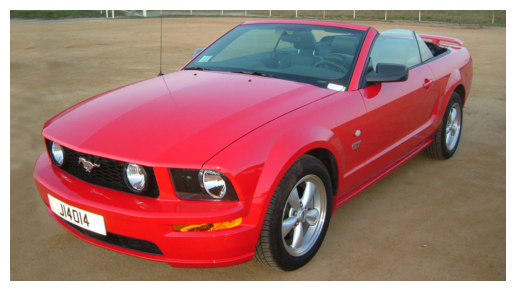

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

=== Prediction Check ===
True Label:       class_107
Predicted Label:  class_107
Confidence:       87.31%
Correct: YES ✔️


(True, 'class_107', np.float32(87.31461))

In [ ]:
sample = val_df.sample(1).iloc[0]
img_path = sample["filename"]
true_label = sample["label"]

img_pil = Image.open(img_path).convert("RGB")

plt.imshow(img_pil)
plt.axis("off")
plt.show()

check_prediction(img_pil, true_label)


In [ ]:
history.history


{'accuracy': [0.13067027926445007,
  0.3161814510822296,
  0.3832091987133026,
  0.41841569542884827,
  0.4448205828666687,
  0.4759647846221924,
  0.5260663628578186,
  0.517264723777771,
  0.5429925322532654,
  0.553825318813324,
  0.5626269578933716,
  0.6012187004089355],
 'loss': [4.495237350463867,
  3.4390594959259033,
  3.1317572593688965,
  2.8963472843170166,
  2.760650873184204,
  2.5718088150024414,
  2.455357551574707,
  2.383699417114258,
  2.288191795349121,
  2.203310251235962,
  2.1366069316864014,
  2.042992115020752],
 'top_k_categorical_accuracy': [0.39133378863334656,
  0.6445497870445251,
  0.7142857313156128,
  0.7630331516265869,
  0.8043330907821655,
  0.8077183365821838,
  0.8408936858177185,
  0.8483412265777588,
  0.8788083791732788,
  0.8788083791732788,
  0.8855788707733154,
  0.9018280506134033],
 'val_accuracy': [0.2540540397167206,
  0.4243243336677551,
  0.5027027130126953,
  0.5243242979049683,
  0.5297297239303589,
  0.591891884803772,
  0.5567567348

In [ ]:
history_ft.history


{'accuracy': [0.3710223436355591,
  0.4793500304222107,
  0.5260663628578186,
  0.553825318813324,
  0.5890318155288696,
  0.6418415904045105,
  0.6472579836845398,
  0.6777251362800598,
  0.6872037649154663,
  0.7075152397155762,
  0.7142857313156128,
  0.7318889498710632,
  0.7643872499465942,
  0.7535545229911804,
  0.7637102007865906,
  0.7840216755867004,
  0.8124576807022095,
  0.7894380688667297,
  0.8036560416221619,
  0.8178740739822388,
  0.8111035823822021,
  0.8361543416976929,
  0.8300609588623047,
  0.8354772925376892,
  0.8442789316177368,
  0.8537576198577881,
  0.8537576198577881,
  0.8551117181777954,
  0.8605281114578247,
  0.8496953248977661],
 'loss': [2.9764506816864014,
  2.4916703701019287,
  2.347292184829712,
  2.178382635116577,
  2.095968008041382,
  1.9756814241409302,
  1.9259607791900635,
  1.8179112672805786,
  1.8252251148223877,
  1.7067011594772339,
  1.7164121866226196,
  1.6543307304382324,
  1.6062644720077515,
  1.6047598123550415,
  1.60074579715